In [2]:

# import libraries
# MIT License

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, confusion_matrix,\
roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, recall_score,\
precision_recall_fscore_support

from sklearn.inspection import permutation_importance

# import classificators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# import feature selection
from sklearn.feature_selection import VarianceThreshold 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# import sampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
# K-Nearest Neighbor OveRsampling (KNNOR)
from knnor import data_augment

# import classificators
from sklearn.ensemble import RandomForestClassifier

# import regressors
from sklearn.ensemble import RandomForestRegressor

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from scipy.special import inv_boxcox


# import library for feature engineering
# autofeat: Automated Feature Engineering Toolkit
# @inproceedings{horn2019autofeat,
#   title={The autofeat Python Library for Automated Feature Engineering and Selection},
#   author={Horn, Franziska and Pack, Robert and Rieger, Michael},
#   booktitle={Joint European Conference on Machine Learning and Knowledge Discovery in Databases},
#   pages={111--120},
#   year={2019},
#   organization={Springer}
# }

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor


from autofeat import FeatureSelector
# import system
import os
import sys

import scipy.stats as stats

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# import scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sigfig import round

In [43]:
samplers = {"None": None,
            "SMOTE": SMOTE(random_state=33),
            "BorderlineSMOTE1": BorderlineSMOTE(random_state=33, kind="borderline-1"),
            "BorderlineSMOTE2": BorderlineSMOTE(random_state=33, kind="borderline-2"),
            "SVMSMOTE": SVMSMOTE(random_state=33),
            "ADASYN": ADASYN(random_state=33),
            "SMOTEENN": SMOTEENN(random_state=33),
            }

feature_selectors_clf = {
    "None": None,
    "VarianceThreshold": VarianceThreshold(threshold=0.1),
    "f_classif": SelectKBest(f_classif, k=5),
    "mutual_info_classif": SelectKBest(mutual_info_classif, k=5),  # k reduced to 2
    "FeatureSelector": FeatureSelector()  # Ensure compatibility
}

# Classification

In [4]:
X = pd.read_csv('../data/cls/cls_encoder.csv')
y = pd.read_csv('../data/cls/cls_target.csv')
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)
y_df = y_df.values.ravel()

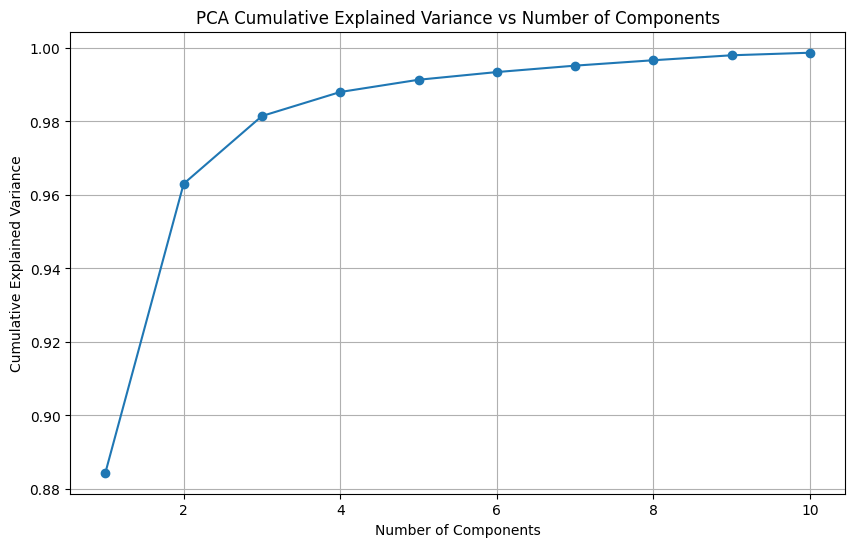

In [581]:
def decide_PCA_n_components(df, min_n, max_n):
    cumulative_variances = []
    n_components_list = range(min_n, max_n + 1)

    for n in n_components_list:
        pca = PCA(n_components=n)
        pca.fit(df)
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        cumulative_variances.append(cumulative_variance[-1])  # Store the last (cumulative) value
        
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_list, cumulative_variances, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance vs Number of Components')
    plt.grid(True)
    plt.show()
    return None

decide_PCA_n_components(X_df, 1, 10)

In [44]:
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, fbeta_score

def grid_search_sampler(model, feature_selector, df_X, y_df, samplers):
    results = []
    
    # Data Splitting
    X_train, X_test, y_train, y_test = train_test_split(df_X, y_df, test_size=0.2, random_state=33)
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for sampler_name, sampler in samplers.items():
        
        # Resampling
        if sampler_name != "None":
            X_train_res, y_train_res = sampler.fit_resample(X_train_scaled, y_train)
        else:
            X_train_res = X_train_scaled
            y_train_res = y_train
        
        # Feature Selection
        X_train_selected = feature_selector.fit_transform(X_train_res, y_train_res)
        X_test_selected = feature_selector.transform(X_test_scaled)

        # Fit PCA after Feature Selection
        pca = PCA(n_components=2)
        X_train_pca = pca.fit_transform(X_train_selected)
        X_test_pca = pca.transform(X_test_selected)

        # Model Training and Prediction
        model.fit(X_train_pca, y_train_res)
        y_pred = model.predict(X_test_pca)
        y_probabilities = model.predict_proba(X_test_pca)[:,1]

        # Performance Metrics
        roc_auc = roc_auc_score(y_test, y_probabilities)  # Corrected to use probabilities
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, output_dict=True)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Storing Results
        each_result = {
            'Sampler': sampler_name,
            'ROC_AUC': roc_auc,
            "recall": recall,
            "f1_score": f1,
            'Confusion_Matrix': cm
        }
        results.append(each_result)
        
        # progress bar
        sys.stdout.write('\r')
        sys.stdout.write("Progress: %d%%" % (100 * (list(samplers).index(sampler_name) + 1) / len(samplers)))
        sys.stdout.flush()

    return pd.DataFrame(results)

In [45]:
feature_seleactor = FeatureSelector()
result_sampler = grid_search_sampler(LogisticRegression(),feature_seleactor, X_df, y_df, samplers)

Progress: 100%

In [46]:
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, fbeta_score

def grid_search_features(model, feature_selectors, df_X, y_df, sampler):
    
    results = []
    
    # Splitting the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df_X, y_df, test_size=0.2, random_state=33)
    
    # Resampling the training data using the provided sampler
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    
    # Scaling the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)

    for feature_selector_name, feature_selector in feature_selectors.items():
        # Feature selection
        if feature_selector_name != "None":
            X_train_selected = feature_selector.fit_transform(X_train_scaled, y_train_res)
            X_test_selected = feature_selector.transform(X_test_scaled)
        else:
            # Use the scaled data as is if no feature selector is specified
            X_train_selected = X_train_scaled
            X_test_selected = X_test_scaled

        # Check the number of features after selection
        n_features = X_train_selected.shape[1]
        
        if n_features > 1:
            # Fit PCA if enough features are available
            pca = PCA(n_components=min(n_features, 2))  # Adjust n_components based on available features
            X_train_pca = pca.fit_transform(X_train_selected)
            X_test_pca = pca.transform(X_test_selected)
        else:
            # Skip PCA if only one feature is present
            X_train_pca = X_train_selected
            X_test_pca = X_test_selected

        # Model Training and Prediction
        model.fit(X_train_pca, y_train_res)
        y_pred = model.predict(X_test_pca)
        y_probabilities = model.predict_proba(X_test_pca)[:, 1]

        # Performance Metrics
        roc_auc = roc_auc_score(y_test, y_probabilities)  # Using probabilities for ROC AUC
        cm = confusion_matrix(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        # Storing Results
        each_result = {
            'feature selector name': feature_selector_name,
            'ROC_AUC': roc_auc,
            "f1_score": f1,
            "recall": recall,
            'Confusion_Matrix': cm
        }
        results.append(each_result)
        
        # Progress bar
        sys.stdout.write('\r')
        sys.stdout.write(f"Progress: {(100 * (list(feature_selectors).index(feature_selector_name) + 1) // len(feature_selectors))}%")
        sys.stdout.flush()

    return pd.DataFrame(results)

In [47]:
sampler = SVMSMOTE(random_state=33)
result_feature_selector = grid_search_features(LogisticRegression(), feature_selectors_clf, X_df, y_df, sampler)

Progress: 100%

In [48]:
def plot_confusion_matrix(keywords,results_df):
    num_samplers = len(results_df)
    fig, axes = plt.subplots(1, num_samplers, figsize=(15, 5))
    
    for idx, row in results_df.iterrows():
        sns.heatmap(row['Confusion_Matrix'], annot=True, fmt='d', ax=axes[idx])
        axes[idx].set_title(row[keywords])
        axes[idx].set_xlabel('Predicted Labels')
        axes[idx].set_ylabel('True Labels')
    
    plt.tight_layout()
    plt.show()

In [49]:
def calculate_profit(tp, fp, fn, tn, benefit_tp, cost_fp, cost_fn, benefit_tn):
    total_profit = (tp * benefit_tp) - (fp * cost_fp) - (fn * cost_fn) + (tn * benefit_tn)
    return total_profit

def plot_total_profit_bar_chart(keywords,results_df):
    # Define cost-benefit parameters
    benefit_tp = 60   # Benefit from a True Positive
    cost_fp = 40      # Cost of a False Positive
    cost_fn = 55      # Cost of a False Negative
    benefit_tn = 10   # Benefit of a True Negative

    plt.figure(figsize=(12, 8))

    total_profits = []

    for idx, row in results_df.iterrows():
        keyword = row[keywords]

        # Extract confusion matrix components
        tn, fp = row['Confusion_Matrix'][0]
        fn, tp = row['Confusion_Matrix'][1]

        # Calculate total profit
        total_profit = calculate_profit(tp, fp, fn, tn, benefit_tp, cost_fp, cost_fn, benefit_tn)
        total_profits.append((keyword, total_profit))

    # Sort feature selectors by total profit for better visualization
    total_profits.sort(key=lambda x: x[1], reverse=True)

    # Plotting
    feature_selectors, profits = zip(*total_profits)
    plt.bar(feature_selectors, profits, color='skyblue')
    plt.ylabel('Total Estimated Profit')
    plt.title('Total Profit Comparison for Different Feature Selectors')
    plt.xticks(rotation=45)
    plt.show()

In [50]:
def visualize_results(keywords,results_df):
    # ROC AUC Score Visualization
    plot_confusion_matrix(keywords,results_df)
    plot_total_profit_bar_chart(keywords,results_df)
    
    # Extracting recall and F1-score from classification reports
    f1_scores = []
    recall = []
    roc_auc = []
    keyword = results_df[keywords].tolist()

    for idx, row in results_df.iterrows():
        f1_scores.append(round(row['f1_score'], decimals=3))
        recall.append(round(row['recall'], decimals=3))
        roc_auc.append(round(row['ROC_AUC'], decimals=3))

    # Creating a DataFrame for visualization
    metrics_df = pd.DataFrame({
        keywords: keyword,
        'F1-Score': f1_scores,
        "recall": recall,
        "ROC AUC": roc_auc,
    })
    
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(x=keywords, y='value', hue='variable', data=pd.melt(metrics_df, id_vars=keywords))
    plt.title('Recall and F1-Score for Different Samplers')
    plt.ylabel('Score')
    plt.xlabel(keywords)
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.show()

In [32]:
result_feature_selector

,feature selector name,ROC_AUC,f1_score,recall,Confusion_Matrix
0,None,0.693923,0.683238,0.656833,"[[3155, 1523], [536, 786]]"
1,VarianceThreshold,0.693923,0.683238,0.656833,"[[3155, 1523], [536, 786]]"
2,f_classif,0.715305,0.777056,0.773667,"[[3940, 738], [620, 702]]"
3,mutual_info_classif,0.717248,0.768526,0.760000,"[[3802, 876], [564, 758]]"
4,mutual_info_regression,0.728602,0.766726,0.757667,"[[3785, 893], [561, 761]]"
5,FeatureSelector,0.726897,0.745702,0.732833,"[[3647, 1031], [572, 750]]"


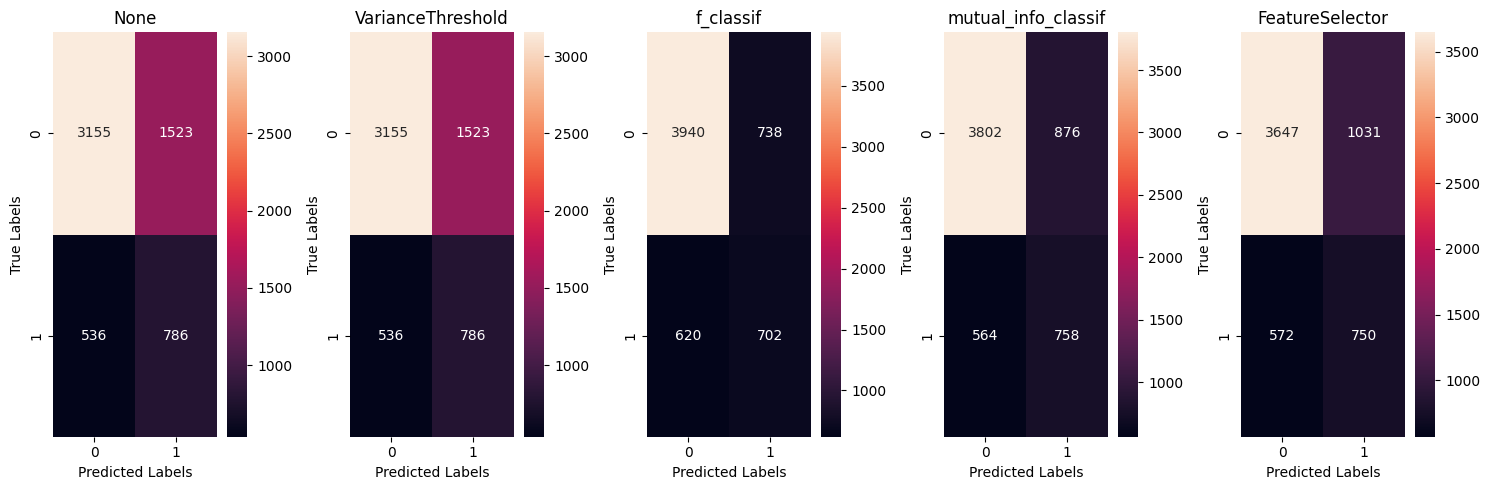

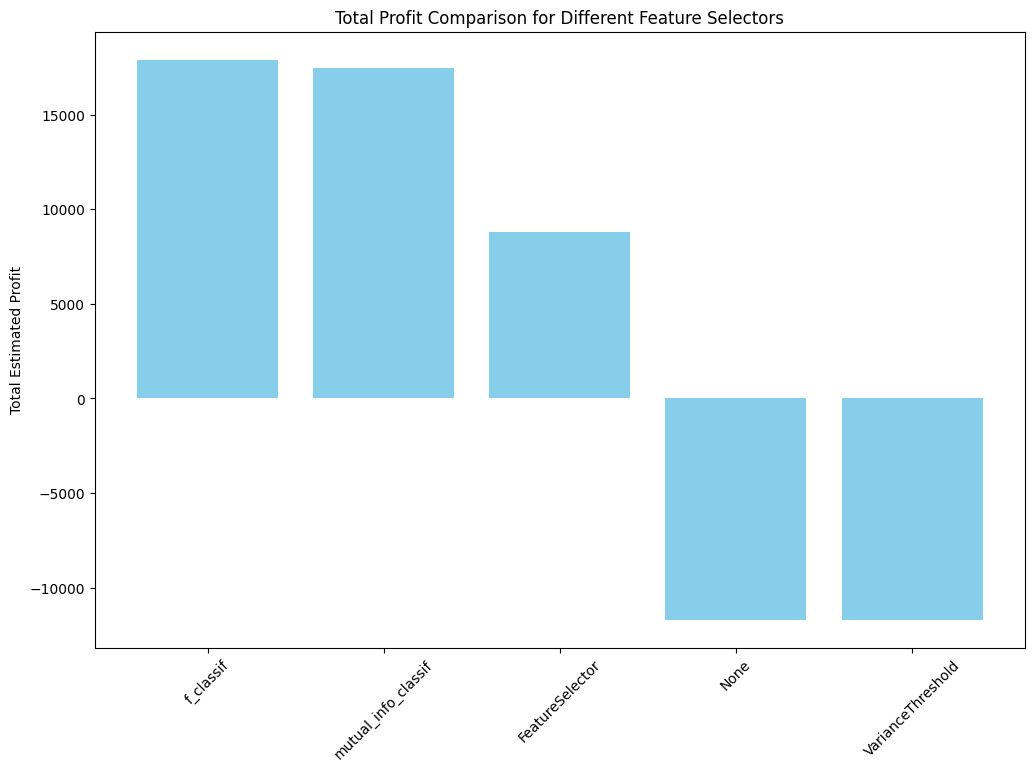

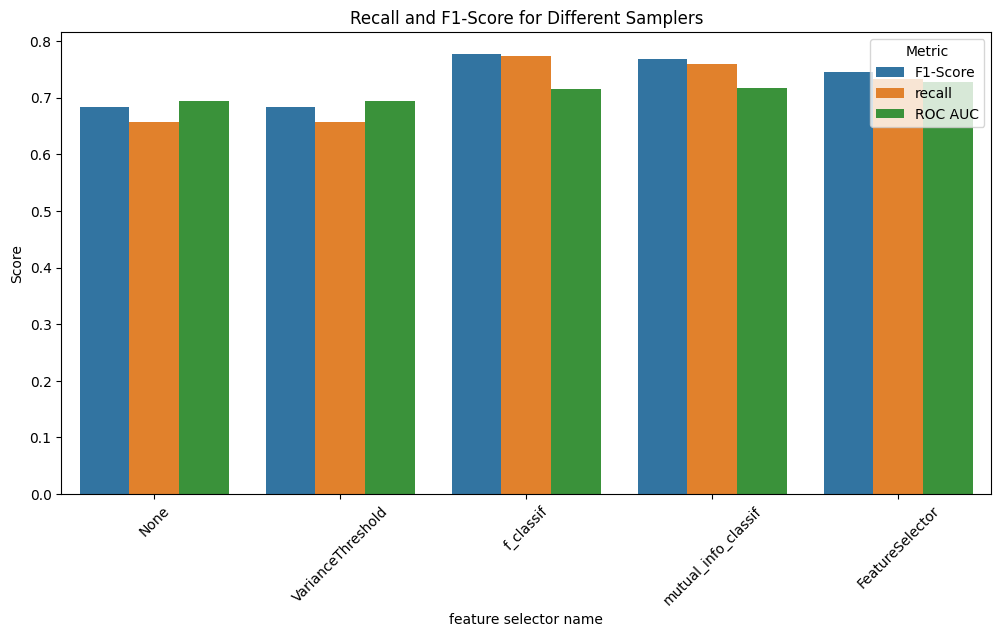

In [51]:
# visualize_results('Sampler',result)
visualize_results('feature selector name',result_feature_selector)

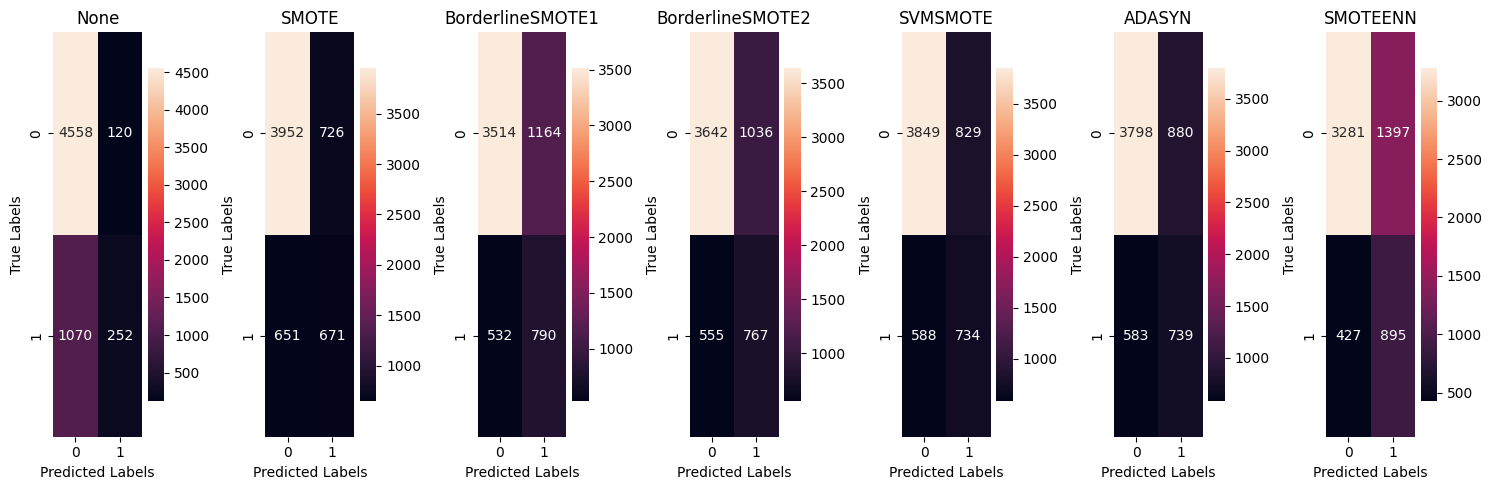

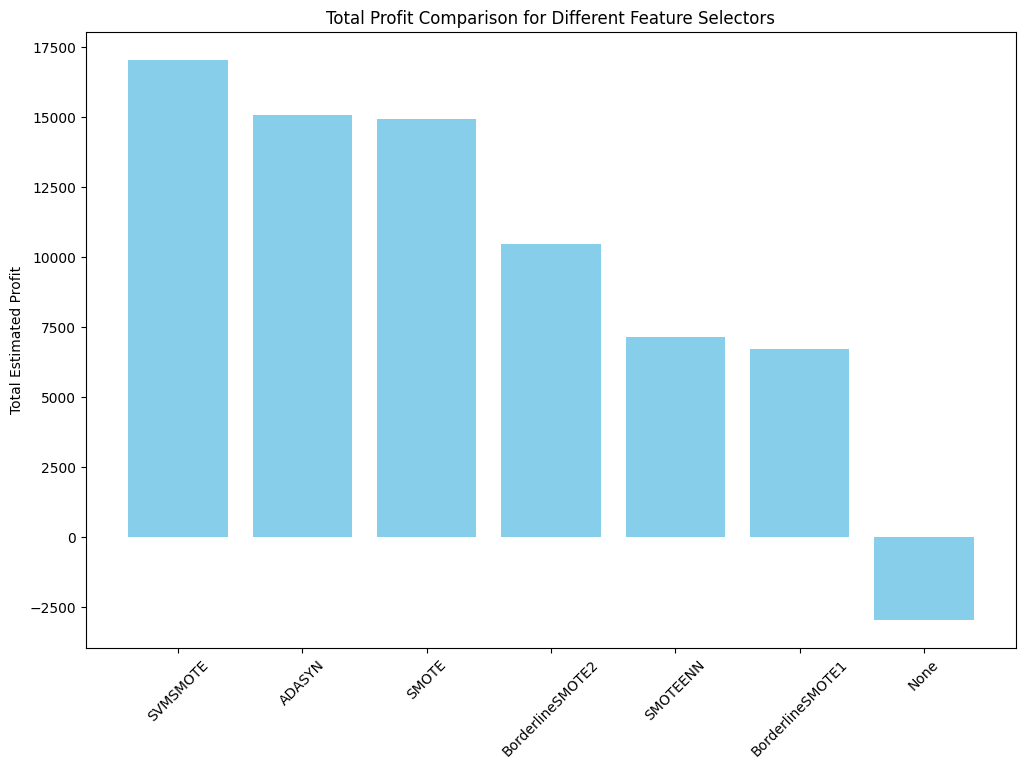

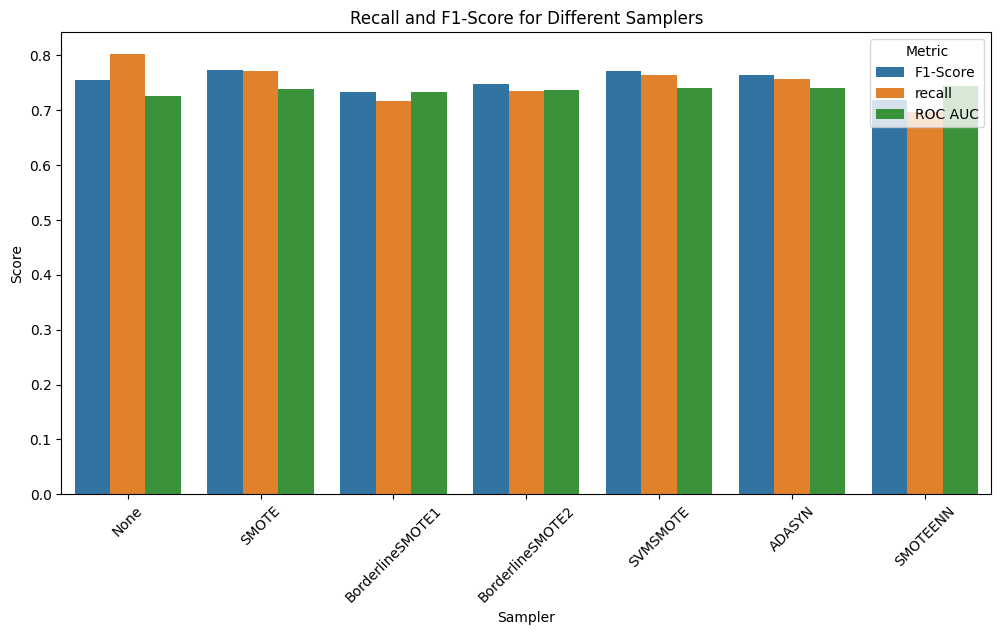

In [52]:
# Do feature importance
visualize_results('Sampler',result_sampler)

In [592]:
final_sampler = SVMSMOTE(random_state=33)
final_feature_selector = SelectKBest(f_classif, k=5)

# Regression

In [3]:
X = pd.read_csv('../data/reg/reg_encoder.csv')
y = pd.read_csv('../data/reg/reg_target.csv')

In [4]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [8]:
X.shape

(29791, 11)

In [5]:
# combine features and create new features

# Education and others
X_df['Edu_Marrige'] = X_df['EDUCATION'] * X_df['MARRIAGE'] # success
X_df['Sex_Age2'] = X_df["SEX"] * X_df["age_cluster_k"] ** 2 # success

X_df['Edu_Marrige2'] = X_df['EDUCATION'] **2 * X_df['MARRIAGE'] # success

X_df['Edu3_Sex'] = X_df["EDUCATION"] ** 3 * X_df["SEX"] # success
X_df['Edu3'] = X_df['EDUCATION'] ** 3 # success

# Sex and others
X_df['Marriage4'] = X_df['MARRIAGE'] ** 4 # success

# Marriage and others
X_df['Marriage_Age3'] = X_df['MARRIAGE'] * X_df['age_cluster_k'] ** 3 # success

# Combine three features
X_df['Sex_edu3_mar'] = X_df["SEX"] * X_df["EDUCATION"]**3 * X_df["MARRIAGE"] # success
X_df['Sex2_mar_age2'] = X_df["SEX"]**2 * X_df["MARRIAGE"] * X_df["age_cluster_k"] ** 2
X_df['Edu3_mar2_age'] = X_df["EDUCATION"]**3 * X_df["MARRIAGE"]**2 * X_df["age_cluster_k"]

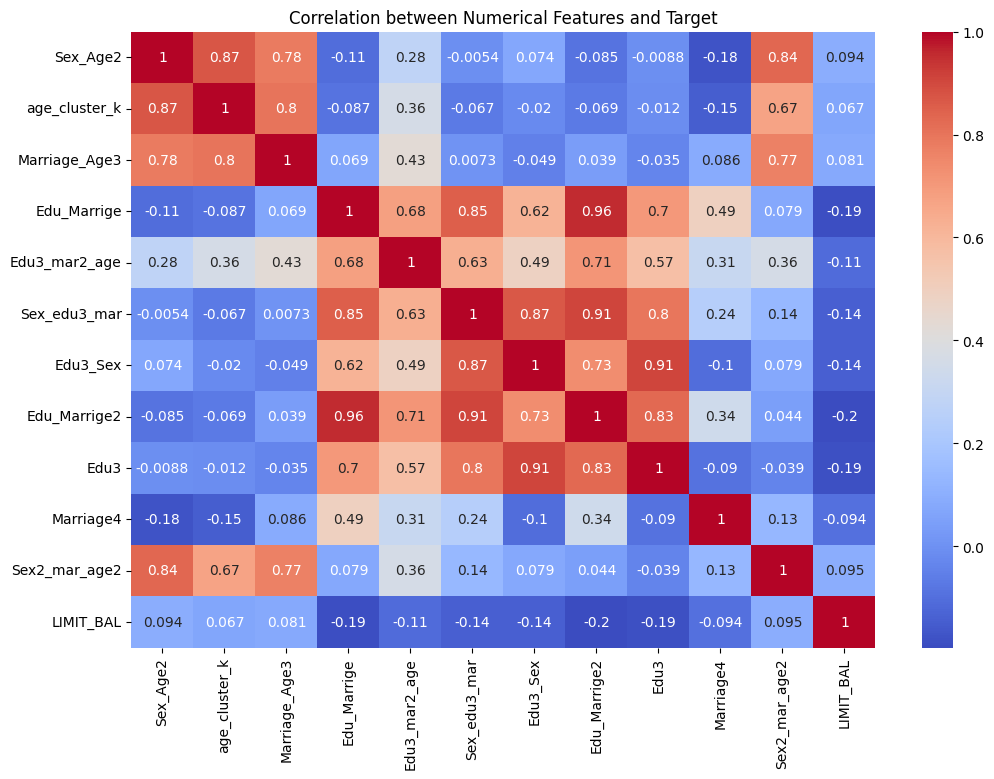

In [6]:
whole_features = X_df.columns.tolist()
category_features = ["SEX", "EDUCATION", "MARRIAGE"]
numerical_features = list(set(whole_features) - set(category_features))

# find correlation between numerical features and target

# Selecting only the numerical features and the target from your DataFrame
num_df = X_df[numerical_features]

combined_df = pd.concat([num_df, y_df["LIMIT_BAL"]], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Features and Target')
plt.show()

In [7]:
# Perform the ANOVA F-test
X = X_df[numerical_features]  # numerical_features from your previous list
y = y_df['LIMIT_BAL']  # Replace 'target' with the actual column name of your target variable

f_values, p_values = f_regression(X, y)

# Create a DataFrame to see the F-values and p-values for each feature
anova_results = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})

# Sort the results by p-value to see which features are most statistically significant
anova_results.sort_values('p-value')

,Feature,F-value,p-value
7,Edu_Marrige2,1194.216818,1.299533e-256
3,Edu_Marrige,1132.095683,1.280700e-243
8,Edu3,1074.425098,1.563690e-231
5,Sex_edu3_mar,632.319291,4.324448e-138
6,Edu3_Sex,631.941831,5.203774e-138
4,Edu3_mar2_age,374.548565,6.189005e-83
10,Sex2_mar_age2,269.867152,2.237004e-60
0,Sex_Age2,266.233255,1.363378e-59
9,Marriage4,265.174571,2.308476e-59
2,Marriage_Age3,197.285891,1.134482e-44


In [663]:
import category_encoders as ce

whole_features = X_df.columns.tolist()
category_features = ["SEX", "EDUCATION", "MARRIAGE"]
numerical_features = list(set(whole_features) - set(category_features))

def apply_binary_encoding(df, categorical_columns):
    # Initialize the Binary Encoder
    encoder = ce.BinaryEncoder(cols=categorical_columns)

    # Fit and transform the DataFrame
    df_encoded = encoder.fit_transform(df)

    return df_encoded

X_df = apply_binary_encoding(X_df, category_features)

In [664]:
y_additional_test = y_df['Default_Payment']
y = y_df['LIMIT_BAL']

y_additional_test_df = pd.DataFrame(y_additional_test)

y_df = pd.DataFrame(y)
y_df = y_df.values.ravel()
y_additional_test_df = y_additional_test_df.values.ravel()

In [665]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, MinMaxScaler, StandardScaler

In [676]:
def gird_search_transformation_ref(model, X_df, y_df, y_additional_test_df):
    train_X, test_X, train_y, test_y, _ , test_y_additional = train_test_split(X_df, y_df, y_additional_test_df, test_size=0.2, random_state=33)
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)
    result = []
    
    transformations = {
        # Removed transformations that can create inf/-inf values from y without handling
        'Box-Cox': lambda x: boxcox(x + 1)[0],  # Offset x by 1 to handle zero values
        'Yeo-Johnson': lambda x: PowerTransformer(method='yeo-johnson').fit_transform(x.reshape(-1, 1)).flatten(),
        'Quantile': lambda x: QuantileTransformer().fit_transform(x.reshape(-1, 1)).flatten()
    }
    
    for name, transformation in transformations.items():
        # Transforming the target variable
        if name == 'Box-Cox':
            train_y_transformed, fitted_lambda = boxcox(train_y)
        if name == 'Quantile':
            qt = QuantileTransformer(output_distribution='normal')
            train_y_transformed = qt.fit_transform(train_y.reshape(-1, 1)).flatten()
        else:
            train_y_transformed = transformation(train_y)
            
        # Fit the model
        model.fit(train_X_scaled, train_y_transformed)
        
        # Predict and inverse transform if necessary
        pred_y = model.predict(test_X_scaled)
        
        if name == 'Box-Cox':
            pred_y_transformed = inv_boxcox(pred_y, fitted_lambda)
        elif name == 'Yeo-Johnson':
            pt = PowerTransformer(method='yeo-johnson')
            pt.fit(train_y.reshape(-1, 1))
            pred_y_transformed = pt.inverse_transform(pred_y.reshape(-1, 1)).flatten()
        else:
            # For Quantile and other transformations that do not have an exact inverse
            pred_y_transformed = qt.inverse_transform(pred_y.reshape(-1, 1)).flatten()  # This may require a custom inverse function

        pred_y_transformed = [round(val, sigfigs=2) for val in pred_y_transformed]
    
        rmse = np.sqrt(mean_squared_error(test_y, pred_y_transformed))
        mae = mean_absolute_error(test_y, pred_y_transformed)
        r2 = r2_score(test_y, pred_y_transformed)
    
        hits = 0
        total = 0
        for i in range(len(test_y)):
            total += 1
            # if the user defaults
            # if we predicted allowance is lower than the true allowance, then we hit
            if test_y_additional[i] == 1:
                if pred_y_transformed[i] < test_y[i]:
                    hits += 1
            # if the user does not default
            # if we predicted allowance is equal than the true allowance, then we hit
            if test_y_additional[i] == 0:
                if pred_y_transformed[i] <= test_y[i]:
                    hits += 1
                # if we predicted allowance is higher than the true allowance, but within acceptable range, then we hit
                # The acceptable range is defined as 10000 as each jump is 10000
                if pred_y_transformed[i] > test_y[i]:
                    if pred_y_transformed[i] - test_y[i] <= 30000:
                        hits += 1
        
        hit_rate = (hits/total)
    
        result.append({
            'transformation': name,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'model': model,
            'hit_rate': hit_rate,
            'pred_y': pred_y_transformed,
            'true_y': test_y 
        })
        
    return pd.DataFrame(result)

result = gird_search_transformation_ref(RandomForestRegressor(random_state=33), X_df, y_df, y_additional_test_df)

In [677]:
result

,transformation,rmse,mae,r2,model,hit_rate,pred_y,true_y
0,Box-Cox,118001.906373,88561.671421,0.115978,"(DecisionTreeRegressor(max_features=1.0, rando...",0.624098,"[220000.0, 67000.0, 240000.0, 170000.0, 160000...","[70000, 240000, 160000, 50000, 420000, 200000,..."
1,Yeo-Johnson,118001.264993,88562.342675,0.115988,"(DecisionTreeRegressor(max_features=1.0, rando...",0.624098,"[220000.0, 67000.0, 240000.0, 170000.0, 160000...","[70000, 240000, 160000, 50000, 420000, 200000,..."
2,Quantile,117799.208254,89242.490351,0.119013,"(DecisionTreeRegressor(max_features=1.0, rando...",0.611344,"[260000.0, 50000.0, 290000.0, 200000.0, 170000...","[70000, 240000, 160000, 50000, 420000, 200000,..."


In [678]:
# unique value in pred_y
np.unique(result.pred_y[2])

array([ 20000.,  30000.,  50000.,  60000.,  70000.,  77000.,  80000.,
        90000., 100000., 110000., 120000., 130000., 140000., 150000.,
       160000., 170000., 180000., 190000., 200000., 210000., 220000.,
       230000., 240000., 250000., 260000., 270000., 280000., 290000.,
       300000., 320000., 340000., 360000.])

In [679]:
np.unique(result.true_y[2])

array([ 10000,  20000,  30000,  40000,  50000,  60000,  70000,  80000,
        90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000,
       170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000,
       250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000,
       330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000,
       410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000,
       490000, 500000])

/var/folders/20/0y46cgg97gs8kf_s9bthlzgm0000gn/T/ipykernel_59103/1228775250.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result.true_y[2])


<Axes: ylabel='Density'>

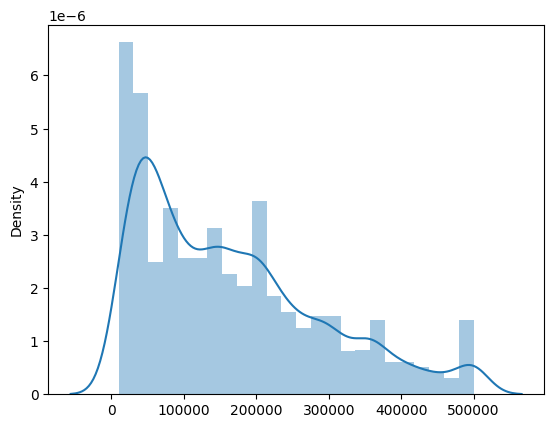

In [680]:
sns.distplot(result.true_y[2])

/var/folders/20/0y46cgg97gs8kf_s9bthlzgm0000gn/T/ipykernel_59103/4217907851.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result.pred_y[0])


<Axes: ylabel='Density'>

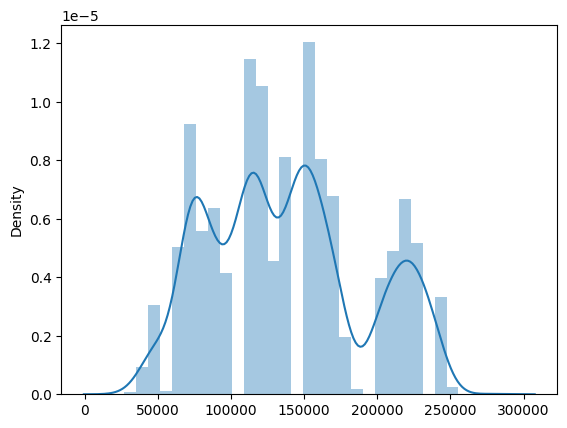

In [681]:
np.unique(result.true_y[0])
# distribution of pred_y
sns.distplot(result.pred_y[0])